# CDAE

- [Collaborative Denoising Auto-Encoders for Top-N Recommender Systems](https://alicezheng.org/papers/wsdm16-cdae.pdf)

## Experiment

- K-fold 사용

In [1]:
import glob
import numpy as np
import pandas as pd
from typing import Callable, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Embedding, Flatten, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import get_file
import zipfile

In [2]:
def load_data(data_size : str) -> pd.DataFrame:
    ''' load Movie Lens data '''

    if data_size == '100k':
        file = get_file('ml-100k.zip', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip')
        file_name = 'ml-100k/*'
    elif data_size == '1m':
        file = get_file('ml-1m.zip', 'http://files.grouplens.org/datasets/movielens/ml-1m.zip')
        file_name = 'ml-1m/ratings.dat'
    elif data_size == '10m':
        file = get_file('ml-10m.zip', 'http://files.grouplens.org/datasets/movielens/ml-10m.zip')
        file_name = 'ml-10M100K/ratings.dat'
    elif data_size == '20m':
        file = get_file('ml-20m.zip', 'http://files.grouplens.org/datasets/movielens/ml-20m.zip')
        file_name = 'ml-20m/ratings.csv'
    elif data_size == '25m':
        file = get_file('ml-25m.zip', 'http://files.grouplens.org/datasets/movielens/ml-25m.zip')
        file_name = 'ml-25m/ratings.csv'
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()

    col_names = ['userId', 'movieId', 'rating', 'timestamp']
    if data_size in ['20m', '25m']:
        ratings = pd.read_csv(file_name, engine = 'python')
    else:
        ratings = pd.read_csv(file_name, sep = '|', delimiter = '::', names = col_names, engine = 'python')
    print(ratings.shape)
    return ratings

In [3]:
ratings = load_data('1m')
ratings.head()

5922816/5917549 [==============================] - 0s 0us/step
(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1. Data Preprocessing

In [4]:
def preprocessing(df: pd.DataFrame, threshold = 4) -> pd.DataFrame:
    df = df[df.rating >= threshold]
    positive = df.groupby('userId')['movieId'].nunique()
    positive = positive.index[positive >= 5]
    df = df[df.userId.isin(positive)]
    return df.reset_index(drop = True)

In [5]:
idx_user_map = ratings.userId.unique()
user_idx_map = {e: i for i, e in enumerate(idx_user_map)}
n_user = idx_user_map.shape[0]
print(f'# of user = {n_user}')

idx_item_map = ratings.movieId.unique()
item_idx_map = {e: i for i, e in enumerate(idx_item_map)}
n_item = idx_item_map.shape[0]
print(f'# of item = {n_item}')

# of user = 6040
# of item = 3706


In [6]:
def Id2idx(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.map(user_idx_map), 
                     movieId = lambda x: x.movieId.map(item_idx_map))

def idx2Id(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.apply(lambda x: idx_user_map[x]), 
                     movieId = lambda x: x.movieId.apply(lambda x: idx_item_map[x]))

In [7]:
ratings = preprocessing(ratings)
ratings = Id2idx(ratings)

print(ratings.shape)
ratings.head(5)

(575272, 4)


,userId,movieId,rating,timestamp
0,0,0,5,978300760
1,0,3,4,978300275
2,0,4,5,978824291
3,0,6,5,978302039
4,0,7,5,978300719


In [8]:
def train_valid_test_split(df: pd.DataFrame) -> pd.DataFrame:
    train_user, test_user = train_test_split(df.userId.unique(), test_size = 0.1, random_state = 7777)

    train, test = map(lambda x: df[df.userId.isin(x)], (train_user, test_user))
    train, test = map(lambda df: df.reset_index(drop = True), (train, test))
    return train, test

def k_fold_split(df:pd.DataFrame, k = 5) -> pd.DataFrame:
    folds = KFold(n_splits = k, shuffle = True, random_state = 7777)
    folds_gen = folds.split(df.userId.unique())
    for _ in range(k):
        train_user, valid_user = next(folds_gen)
        train, valid = map(lambda x: df[df.userId.isin(x)], (train_user, valid_user))
        train, valid = map(lambda df: df.reset_index(drop = True), (train, valid))
        yield train, valid

def query_answer_split(df: pd.DataFrame) -> pd.DataFrame:
    query, answer = train_test_split(df, test_size = 0.2, stratify = df.userId, random_state = 7777)
    query, answer = map(lambda df: df.sort_values(['userId', 'timestamp']), (query, answer))
    query, answer = map(lambda df: df.reset_index(drop = True), (query, answer))
    return query, answer

def list_aggregation(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('userId', as_index = False)[['movieId', 'rating']].agg(list)

In [9]:
def train_generator(df: pd.DataFrame,
                    n_item: int,
                    batch_size: int,
                    implicit = True,
                    threshold = 4,
                    NS = 5,
                    corruption = 0.5,
                    user_specific = True) -> Tuple[np.array, np.array]:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r >= threshold else 0 for r in x])

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        np.random.shuffle(Ids)
        
        for batch_step in range(n_batch):
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch = np.zeros(shape = (batch_Id.size, n_col))
            for i, idx in enumerate(batch_Id):
                pos = np.array(profile[idx])
                neg_n = len(pos) * NS
                neg = np.random.choice(np.delete(np.arange(n_col), pos), neg_n)
                p = np.random.uniform(0, 1, size = pos.shape)
                cor = pos[p < corruption]

                batch[i, pos] = rating[idx]
                batch[i, neg] = np.finfo(float).eps
                batch[i, cor] = 0
   
            if user_specific:
                yield (batch, batch_Id), batch
            else:
                yield batch, batch

In [10]:
def valid_generator(query: pd.DataFrame,
                    answer: pd.DataFrame,
                    n_item: int,
                    batch_size: int,
                    implicit = True,
                    threshold = 4,
                    user_specific = True) -> Tuple[np.array, np.array]:

    n_row = query.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile_q = query['movieId']
    profile_a = answer['movieId']
    if implicit:
        rating_q = query['rating'].apply(lambda x: [1 if r >= threshold else 0 for r in x])
        rating_a = answer['rating'].apply(lambda x: [1 if r >= threshold else 0 for r in x])
    else:
        rating_q = query['rating']
        rating_a = answer['rating']

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        for batch_step in range(n_batch):
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch_q = np.zeros(shape = (batch_Id.size, n_col))
            batch_a = np.zeros(shape = (batch_Id.size, n_col))

            for i, idx in enumerate(batch_Id):
                obs = np.array(profile_q[idx]) # observed
                ubs = np.array(profile_a[idx]) # unobserved

                batch_q[i, obs] = rating_q[idx]
                batch_a[i, ubs] = rating_a[idx]

            if user_specific:
                yield (batch_q, batch_Id), batch_a
            else:
                yield batch_q, batch_a

In [11]:
def masked_mae(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = tf.cast(tf.not_equal(y_true, masked_value), dtype = 'float32')
    masked_ae = K.abs(mask_true * (y_true - y_pred))
    return K.sum(masked_ae, axis = -1) / K.sum(mask_true, axis = -1)

def masked_rmse(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_se = K.square(mask_true * (y_true - y_pred))
    masked_mse = K.sum(masked_se, axis = -1) / K.sum(mask_true, axis = -1)
    return K.sqrt(masked_mse)
   
def masked_cross_entropy(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    ce = y_true * K.log(y_pred + K.epsilon()) + (1 - y_true) * K.log(1 - y_pred + K.epsilon())
    masked_ce = mask_true * ce
    return -K.sum(masked_ce, axis = -1) / K.sum(mask_true, axis = -1)

def batch_ndcg(y_true, y_pred, k = 100):
    rec = tf.argsort(y_pred, axis = -1, direction = 'DESCENDING')[:, :k]
    gt = tf.identity(y_true)

    row = tf.repeat(tf.range(tf.shape(gt)[0]), k)
    row = tf.expand_dims(row, axis = 1)
    col = tf.reshape(rec, shape = [-1])
    col = tf.expand_dims(col, axis = 1)
    loc = tf.concat([row, col], axis = 1)

    top_k = tf.reshape(tf.gather_nd(gt, loc), shape = tf.shape(rec))
    ideal = tf.sort(top_k, axis = 1, direction = 'DESCENDING')

    weight = tf.range(2, 102, dtype = 'float32')
    weight = tf.math.log(weight)
    weight = tf.math.reciprocal(weight)
    
    dcg = tf.reduce_sum(top_k * weight, axis = 1)    
    idcg = tf.reduce_sum(ideal * weight, axis = 1)
    return dcg / tf.where(idcg == 0, 1.0, idcg)

In [12]:
def CDAE(n_user: int,
         n_item: int,
         latent_dim = 50,
         activation = 'linear',
         optimizer = 'adam',
         learning_rate = 0.001,
         kernel_initializer = None,
         kernel_regularizer = None,
         user_specific = True) -> Callable:

    if not kernel_initializer:
        kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)
    if not kernel_regularizer:
        kernel_regularizer = l2(0.0001)
    
    inputs = x = Input(shape = (n_item, ), name = 'input')
    x = Dense(latent_dim, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'encoder')(x)

    if user_specific:
        users = u = Input(shape = (1, ), dtype = 'int32', name = 'user')
        u = Embedding(input_dim = n_user, output_dim = latent_dim, input_length = 1, embeddings_regularizer = kernel_regularizer)(u)
        u = Flatten()(u)
        x = concatenate([x, u], axis = 1)
    
    outputs = Dense(n_item, activation = 'sigmoid', kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'decoder')(x)
    if user_specific:
        model = Model(inputs = [inputs, users], outputs = outputs)
    else:
        model = Model(inputs = inputs, outputs = outputs)

    model.compile(optimizer = optimizer, loss = masked_cross_entropy, metrics = [batch_ndcg, masked_rmse])
    return model

In [13]:
def test_predictor(df: pd.DataFrame,
                   models: list, 
                   n_item: int, 
                   batch_size: int, 
                   implicit = True,
                   threshold = 4,
                   user_specific = True,
                   top_N = 20) -> float:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r >= threshold else 0 for r in x])

    res = []
    steps = int(np.ceil(n_row / batch_size))
    for batch_step in range(steps):
        lower = batch_step * batch_size
        upper = lower + batch_size

        batch_Id = Ids[lower: upper]
        y_true = np.zeros(shape = (batch_Id.size, n_col))
        for i, idx in enumerate(batch_Id):
            y_true[i, profile[idx]] = rating[idx]

        y_pred = np.zeros(shape = (batch_Id.size, n_col))
        if user_specific:
            for model in models:
                y_pred += model.predict([y_true, batch_Id], verbose = 0)
        else:
            for model in models:
                y_pred += model.predict(y_true, verbose = 0)
        y_pred /= len(models)
        pred = np.argsort(np.where(y_true == 1, 0, 1) * y_pred, axis = -1)[:, :-top_N-1:-1]
        res.append(pred)
    return np.concatenate(res)

In [14]:
def show_history(hist, loss: str, metric: str) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    ax1.plot(hist.history[f'{loss}'])
    ax1.plot(hist.history[f'val_{loss}'])
    ax1.set_title('Loss', fontsize = 20)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['loss', 'val_loss'], loc = 'upper right')

    ax2.plot(hist.history[f'{metric}'])
    ax2.plot(hist.history[f'val_{metric}'])
    ax2.set_title('Metric', fontsize = 20)
    ax2.set_ylabel('metric')
    ax2.set_xlabel('epoch')
    ax2.legend(['metric', 'val_metric'], loc = 'upper right')
    plt.show()

In [15]:
def ndcg(gt, rec):
    dcg, idcg = 0.0, 0.0
    k = 0
    for i, r in enumerate(rec):
        if r in gt:
            dcg += 1.0 / np.log(i + 2)
            idcg += 1.0 / np.log(k + 2)
            k += 1
    return dcg / np.max([1, idcg])

def recall(gt, rec):
    res = [r for r in rec if r in gt]
    return len(res) / len(gt)

def precision(gt, rec):
    res = [r for r in rec if r in gt]
    return len(res) / len(rec)

def precision_k(gt, rec, k):
    rec_k = rec[:k+1]
    res = [r for r in rec_k if r in gt]
    return len(res) / k

def AP_k(gt, rec, k = 20):
    res = 0
    for i in range(k):
        if rec[i] in gt:
            res += precision_k(gt, rec, i+1)
    return res / min(k, len(gt))

In [16]:
def evaluation(true: pd.DataFrame, pred):
    m_ndcg = 0
    m_recall = 0
    m_precision = 0
    map_k = 0
    for i in range(len(pred)):
        rec = pred[i]
        gt = true.at[i, 'movieId']
        m_ndcg += ndcg(gt, rec)
        m_recall += recall(gt, rec)
        m_precision += precision(gt, rec)
        map_k += AP_k(gt, rec)
    m_ndcg /= len(pred)
    m_recall /= len(pred)
    m_precision /= len(pred)
    map_k /= len(pred)
    return m_ndcg, m_recall, m_precision, map_k

## 2. DAE

In [17]:
model = CDAE(n_user, n_item, latent_dim = 512, user_specific = False)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3706)]            0         
_________________________________________________________________
encoder (Dense)              (None, 512)               1897984   
_________________________________________________________________
decoder (Dense)              (None, 3706)              1901178   
Total params: 3,799,162
Trainable params: 3,799,162
Non-trainable params: 0
_________________________________________________________________


In [18]:
epochs = 200
batch_size = 128

train_valid, test = train_valid_test_split(ratings)
train_valid = k_fold_split(train_valid)

test_q, test_a = query_answer_split(test)
test_q, test_a = map(list_aggregation, (test_q, test_a))

Start learning 0-th fold...
Epoch 1/200
32/32 [==============================] - 1s 38ms/step - loss: 1.1971 - batch_ndcg: 0.4902 - masked_rmse: 0.3750 - val_loss: 2.4758 - val_batch_ndcg: 0.3511 - val_masked_rmse: 0.6696
Epoch 2/200
32/32 [==============================] - 1s 32ms/step - loss: 0.6843 - batch_ndcg: 0.6496 - masked_rmse: 0.2804 - val_loss: 1.9567 - val_batch_ndcg: 0.3650 - val_masked_rmse: 0.6636
Epoch 3/200
32/32 [==============================] - 1s 40ms/step - loss: 0.4747 - batch_ndcg: 0.6951 - masked_rmse: 0.2693 - val_loss: 1.7772 - val_batch_ndcg: 0.3779 - val_masked_rmse: 0.6643
Epoch 4/200
32/32 [==============================] - 1s 40ms/step - loss: 0.3737 - batch_ndcg: 0.6871 - masked_rmse: 0.2566 - val_loss: 1.6704 - val_batch_ndcg: 0.3811 - val_masked_rmse: 0.6619
Epoch 5/200
32/32 [==============================] - 1s 33ms/step - loss: 0.3248 - batch_ndcg: 0.6848 - masked_rmse: 0.2488 - val_loss: 1.5707 - val_batch_ndcg: 0.3891 - val_masked_rmse: 0.6526
Ep

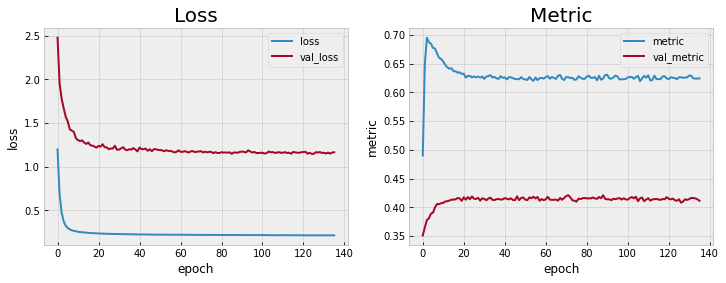

Start learning 1-th fold...
Epoch 1/200
31/31 [==============================] - 1s 37ms/step - loss: 1.2055 - batch_ndcg: 0.4878 - masked_rmse: 0.3779 - val_loss: 2.5177 - val_batch_ndcg: 0.3475 - val_masked_rmse: 0.6610
Epoch 2/200
31/31 [==============================] - 1s 31ms/step - loss: 0.6945 - batch_ndcg: 0.6519 - masked_rmse: 0.2803 - val_loss: 2.0072 - val_batch_ndcg: 0.3524 - val_masked_rmse: 0.6568
Epoch 3/200
31/31 [==============================] - 1s 41ms/step - loss: 0.4841 - batch_ndcg: 0.6910 - masked_rmse: 0.2701 - val_loss: 1.7904 - val_batch_ndcg: 0.3627 - val_masked_rmse: 0.6581
Epoch 4/200
31/31 [==============================] - 1s 42ms/step - loss: 0.3801 - batch_ndcg: 0.6973 - masked_rmse: 0.2576 - val_loss: 1.6296 - val_batch_ndcg: 0.3811 - val_masked_rmse: 0.6486
Epoch 5/200
31/31 [==============================] - 1s 32ms/step - loss: 0.3287 - batch_ndcg: 0.6831 - masked_rmse: 0.2496 - val_loss: 1.6072 - val_batch_ndcg: 0.3851 - val_masked_rmse: 0.6535
Ep

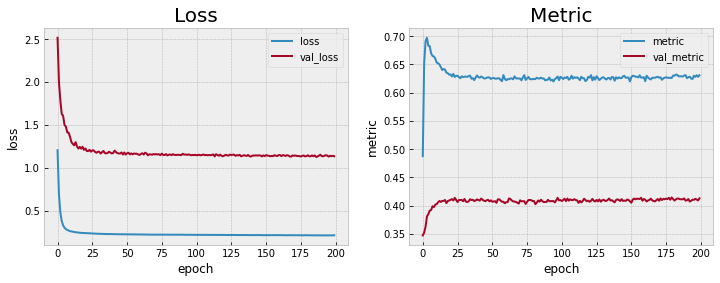

Start learning 2-th fold...
Epoch 1/200
31/31 [==============================] - 1s 37ms/step - loss: 1.2104 - batch_ndcg: 0.4916 - masked_rmse: 0.3769 - val_loss: 2.5869 - val_batch_ndcg: 0.3483 - val_masked_rmse: 0.6611
Epoch 2/200
31/31 [==============================] - 1s 30ms/step - loss: 0.6988 - batch_ndcg: 0.6443 - masked_rmse: 0.2802 - val_loss: 2.0969 - val_batch_ndcg: 0.3525 - val_masked_rmse: 0.6727
Epoch 3/200
31/31 [==============================] - 1s 41ms/step - loss: 0.4887 - batch_ndcg: 0.6893 - masked_rmse: 0.2703 - val_loss: 1.8295 - val_batch_ndcg: 0.3753 - val_masked_rmse: 0.6595
Epoch 4/200
31/31 [==============================] - 1s 42ms/step - loss: 0.3835 - batch_ndcg: 0.6929 - masked_rmse: 0.2576 - val_loss: 1.7633 - val_batch_ndcg: 0.3805 - val_masked_rmse: 0.6673
Epoch 5/200
31/31 [==============================] - 1s 32ms/step - loss: 0.3303 - batch_ndcg: 0.6928 - masked_rmse: 0.2493 - val_loss: 1.6390 - val_batch_ndcg: 0.3859 - val_masked_rmse: 0.6584
Ep

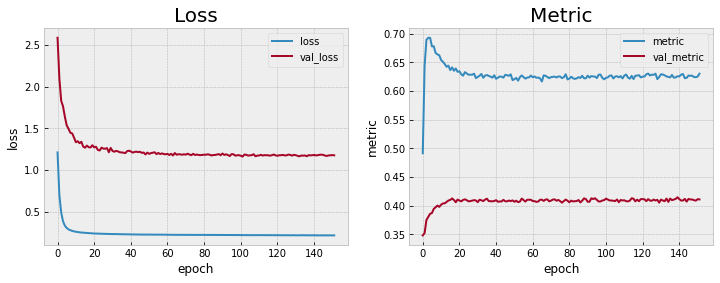

Start learning 3-th fold...
Epoch 1/200
31/31 [==============================] - 1s 37ms/step - loss: 1.2143 - batch_ndcg: 0.4947 - masked_rmse: 0.3805 - val_loss: 2.3545 - val_batch_ndcg: 0.3407 - val_masked_rmse: 0.6581
Epoch 2/200
31/31 [==============================] - 1s 30ms/step - loss: 0.7016 - batch_ndcg: 0.6602 - masked_rmse: 0.2817 - val_loss: 1.9290 - val_batch_ndcg: 0.3554 - val_masked_rmse: 0.6613
Epoch 3/200
31/31 [==============================] - 1s 41ms/step - loss: 0.4894 - batch_ndcg: 0.7044 - masked_rmse: 0.2702 - val_loss: 1.6500 - val_batch_ndcg: 0.3630 - val_masked_rmse: 0.6482
Epoch 4/200
31/31 [==============================] - 1s 42ms/step - loss: 0.3853 - batch_ndcg: 0.6941 - masked_rmse: 0.2585 - val_loss: 1.5395 - val_batch_ndcg: 0.3732 - val_masked_rmse: 0.6414
Epoch 5/200
31/31 [==============================] - 1s 31ms/step - loss: 0.3330 - batch_ndcg: 0.6803 - masked_rmse: 0.2510 - val_loss: 1.4479 - val_batch_ndcg: 0.3823 - val_masked_rmse: 0.6340
Ep

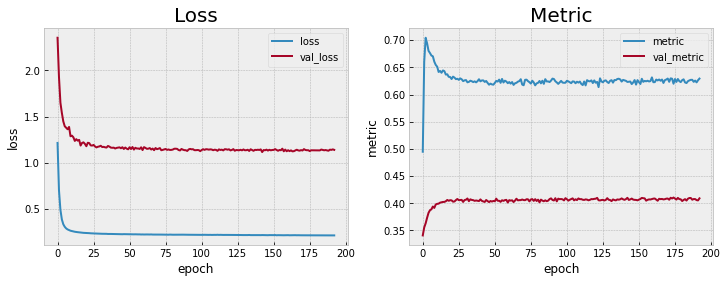

Start learning 4-th fold...
Epoch 1/200
30/30 [==============================] - 1s 39ms/step - loss: 1.2153 - batch_ndcg: 0.4857 - masked_rmse: 0.3795 - val_loss: 2.5053 - val_batch_ndcg: 0.3458 - val_masked_rmse: 0.6663
Epoch 2/200
30/30 [==============================] - 1s 33ms/step - loss: 0.7076 - batch_ndcg: 0.6412 - masked_rmse: 0.2810 - val_loss: 2.0327 - val_batch_ndcg: 0.3602 - val_masked_rmse: 0.6666
Epoch 3/200
30/30 [==============================] - 1s 42ms/step - loss: 0.4952 - batch_ndcg: 0.6823 - masked_rmse: 0.2705 - val_loss: 1.8176 - val_batch_ndcg: 0.3694 - val_masked_rmse: 0.6602
Epoch 4/200
30/30 [==============================] - 1s 43ms/step - loss: 0.3880 - batch_ndcg: 0.6932 - masked_rmse: 0.2586 - val_loss: 1.6571 - val_batch_ndcg: 0.3791 - val_masked_rmse: 0.6544
Epoch 5/200
30/30 [==============================] - 1s 42ms/step - loss: 0.3344 - batch_ndcg: 0.6869 - masked_rmse: 0.2508 - val_loss: 1.5691 - val_batch_ndcg: 0.3829 - val_masked_rmse: 0.6490
Ep

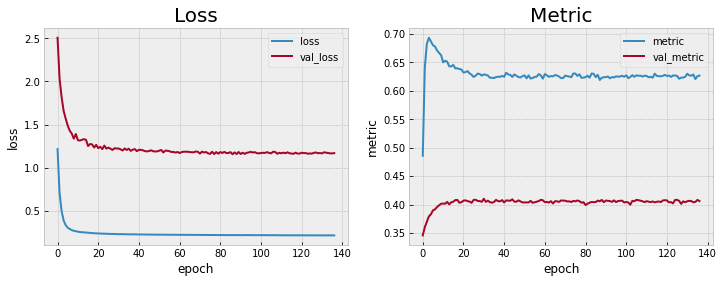

In [19]:
total_hist = []
for i, (train, valid) in enumerate(train_valid):
    print(f'Start learning {i}-th fold...')
    valid_q, valid_a = query_answer_split(valid)
    train, valid_q, valid_a = map(list_aggregation, (train, valid_q, valid_a))
    
    train_gen = train_generator(train, n_item, batch_size, user_specific = False)
    valid_gen = valid_generator(valid_q, valid_a, n_item, batch_size, user_specific = False)

    steps_per_epoch = train.index.size // batch_size + 1
    validation_steps = valid_q.index.size // batch_size + 1

    optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
    model = CDAE(n_user, n_item, latent_dim = 512, optimizer = optimizer, user_specific = False)

    early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
    model_checkpoint = ModelCheckpoint(f'DAE_{i+1}.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)
    hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                     steps_per_epoch = steps_per_epoch, validation_steps = validation_steps,
                     verbose = 1, callbacks = [early_stopping, model_checkpoint])
    show_history(hist, 'loss', 'batch_ndcg')
    total_hist.append(hist)

In [33]:
print(f"The average of nDCG: {np.mean([h.history['val_batch_ndcg'][-1] for h in total_hist]):0.5f}")

The average of nDCG: 0.41012


In [34]:
models = [load_model(f'DAE_{i+1}.h5', compile = False) for i in range(5)]

pred = test_predictor(test_q, models, n_item, batch_size, user_specific = False)
pred

array([[207, 385, 186, ..., 369, 792, 148],
       [ 38,  92,  48, ...,  60, 120, 150],
       [ 44, 217, 714, ..., 205, 642, 432],
       ...,
       [104,  64,  38, ..., 134, 167, 171],
       [ 44,  97, 127, ..., 611,   0, 128],
       [ 64, 127,   5, ..., 246,   0, 206]])

In [35]:
m_ndcg, m_recall, m_precision, map_k = evaluation(test_a, pred)
print(f'nDCG: {m_ndcg:.5f}',
      f'\nRecall: {m_recall:.5f}',
      f'\nPrecision: {m_precision:.5f}',
      f'\nMAP: {map_k:.5f}')

nDCG: 0.53210 
Recall: 0.22295 
Precision: 0.16854 
MAP: 0.14789


## 3. CDAE

In [36]:
model = CDAE(n_user, n_item, latent_dim = 512, user_specific = True)
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
input (InputLayer)              [(None, 3706)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 512)       3092480     user[0][0]                       
__________________________________________________________________________________________________
encoder (Dense)                 (None, 512)          1897984     input[0][0]                      
______________________________________________________________________________________

In [37]:
epochs = 200
batch_size = 128

train_valid, test = train_valid_test_split(ratings)
train_valid = k_fold_split(train_valid)

test_q, test_a = query_answer_split(test)
test_q, test_a = map(list_aggregation, (test_q, test_a))

Start learning 0-th fold...
Epoch 1/200


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


32/32 [==============================] - 2s 57ms/step - loss: 1.6347 - batch_ndcg: 0.4916 - masked_rmse: 0.3754 - val_loss: 2.6819 - val_batch_ndcg: 0.3570 - val_masked_rmse: 0.6682
Epoch 2/200
32/32 [==============================] - 3s 98ms/step - loss: 0.8043 - batch_ndcg: 0.6509 - masked_rmse: 0.2804 - val_loss: 2.1008 - val_batch_ndcg: 0.3629 - val_masked_rmse: 0.6742
Epoch 3/200
32/32 [==============================] - 2s 52ms/step - loss: 0.5134 - batch_ndcg: 0.6772 - masked_rmse: 0.2681 - val_loss: 1.7121 - val_batch_ndcg: 0.3740 - val_masked_rmse: 0.6565
Epoch 4/200
32/32 [==============================] - 3s 98ms/step - loss: 0.3874 - batch_ndcg: 0.6995 - masked_rmse: 0.2565 - val_loss: 1.5999 - val_batch_ndcg: 0.3862 - val_masked_rmse: 0.6478
Epoch 5/200
32/32 [==============================] - 2s 52ms/step - loss: 0.3300 - batch_ndcg: 0.6877 - masked_rmse: 0.2494 - val_loss: 1.5715 - val_batch_ndcg: 0.3956 - val_masked_rmse: 0.6548
Epoch 6/200
32/32 [=======================

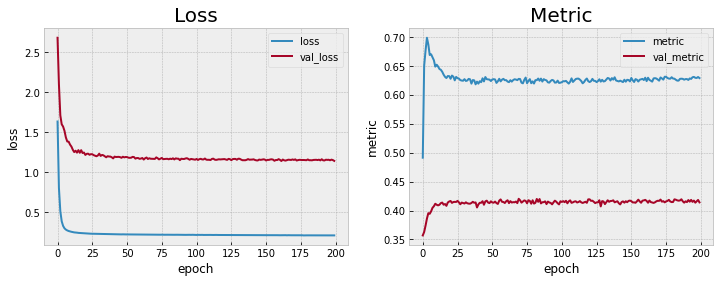

Start learning 1-th fold...
Epoch 1/200


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


31/31 [==============================] - 2s 59ms/step - loss: 1.6492 - batch_ndcg: 0.4892 - masked_rmse: 0.3769 - val_loss: 2.7378 - val_batch_ndcg: 0.3439 - val_masked_rmse: 0.6660
Epoch 2/200
31/31 [==============================] - 3s 101ms/step - loss: 0.8215 - batch_ndcg: 0.6466 - masked_rmse: 0.2799 - val_loss: 2.0840 - val_batch_ndcg: 0.3576 - val_masked_rmse: 0.6605
Epoch 3/200
31/31 [==============================] - 2s 54ms/step - loss: 0.5267 - batch_ndcg: 0.6803 - masked_rmse: 0.2700 - val_loss: 1.8002 - val_batch_ndcg: 0.3743 - val_masked_rmse: 0.6530
Epoch 4/200
31/31 [==============================] - 2s 53ms/step - loss: 0.3956 - batch_ndcg: 0.6888 - masked_rmse: 0.2573 - val_loss: 1.6461 - val_batch_ndcg: 0.3790 - val_masked_rmse: 0.6489
Epoch 5/200
31/31 [==============================] - 2s 57ms/step - loss: 0.3349 - batch_ndcg: 0.6819 - masked_rmse: 0.2500 - val_loss: 1.5558 - val_batch_ndcg: 0.3841 - val_masked_rmse: 0.6466
Epoch 6/200
31/31 [======================

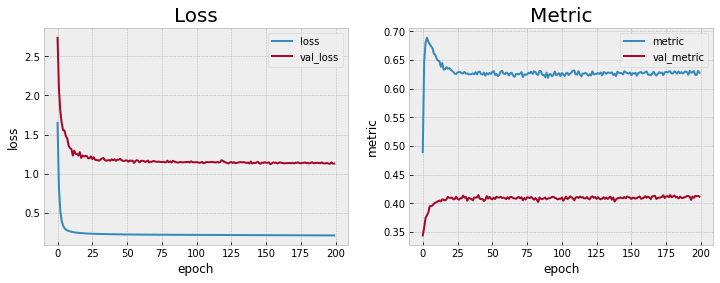

Start learning 2-th fold...
Epoch 1/200


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


31/31 [==============================] - 2s 59ms/step - loss: 1.6604 - batch_ndcg: 0.4915 - masked_rmse: 0.3778 - val_loss: 2.7882 - val_batch_ndcg: 0.3465 - val_masked_rmse: 0.6661
Epoch 2/200
31/31 [==============================] - 3s 100ms/step - loss: 0.8286 - batch_ndcg: 0.6538 - masked_rmse: 0.2813 - val_loss: 2.2285 - val_batch_ndcg: 0.3633 - val_masked_rmse: 0.6757
Epoch 3/200
31/31 [==============================] - 2s 55ms/step - loss: 0.5322 - batch_ndcg: 0.6920 - masked_rmse: 0.2692 - val_loss: 1.8347 - val_batch_ndcg: 0.3717 - val_masked_rmse: 0.6568
Epoch 4/200
31/31 [==============================] - 2s 53ms/step - loss: 0.4011 - batch_ndcg: 0.6953 - masked_rmse: 0.2584 - val_loss: 1.7024 - val_batch_ndcg: 0.3832 - val_masked_rmse: 0.6540
Epoch 5/200
31/31 [==============================] - 3s 100ms/step - loss: 0.3390 - batch_ndcg: 0.6845 - masked_rmse: 0.2508 - val_loss: 1.6292 - val_batch_ndcg: 0.3903 - val_masked_rmse: 0.6529
Epoch 6/200
31/31 [=====================

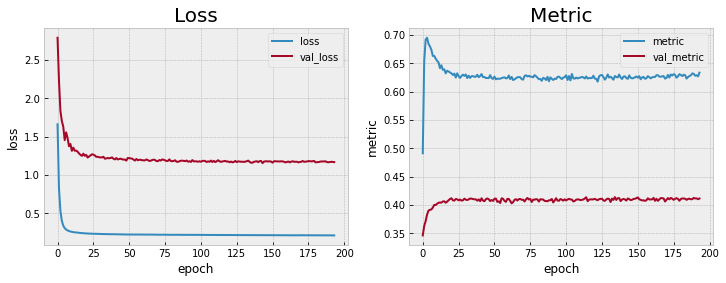

Start learning 3-th fold...
Epoch 1/200


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


31/31 [==============================] - 2s 57ms/step - loss: 1.6661 - batch_ndcg: 0.4894 - masked_rmse: 0.3807 - val_loss: 2.5582 - val_batch_ndcg: 0.3382 - val_masked_rmse: 0.6558
Epoch 2/200
31/31 [==============================] - 3s 100ms/step - loss: 0.8332 - batch_ndcg: 0.6431 - masked_rmse: 0.2819 - val_loss: 1.9354 - val_batch_ndcg: 0.3532 - val_masked_rmse: 0.6542
Epoch 3/200
31/31 [==============================] - 2s 54ms/step - loss: 0.5356 - batch_ndcg: 0.6845 - masked_rmse: 0.2711 - val_loss: 1.7186 - val_batch_ndcg: 0.3643 - val_masked_rmse: 0.6561
Epoch 4/200
31/31 [==============================] - 2s 55ms/step - loss: 0.4026 - batch_ndcg: 0.6818 - masked_rmse: 0.2586 - val_loss: 1.6972 - val_batch_ndcg: 0.3720 - val_masked_rmse: 0.6692
Epoch 5/200
31/31 [==============================] - 2s 53ms/step - loss: 0.3401 - batch_ndcg: 0.6840 - masked_rmse: 0.2510 - val_loss: 1.5497 - val_batch_ndcg: 0.3805 - val_masked_rmse: 0.6518
Epoch 6/200
31/31 [======================

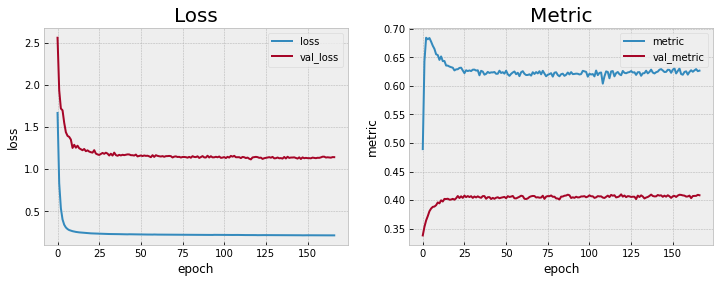

Start learning 4-th fold...
Epoch 1/200


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


30/30 [==============================] - 2s 59ms/step - loss: 1.6678 - batch_ndcg: 0.4961 - masked_rmse: 0.3810 - val_loss: 2.7423 - val_batch_ndcg: 0.3482 - val_masked_rmse: 0.6674
Epoch 2/200
30/30 [==============================] - 3s 105ms/step - loss: 0.8422 - batch_ndcg: 0.6465 - masked_rmse: 0.2807 - val_loss: 2.0134 - val_batch_ndcg: 0.3608 - val_masked_rmse: 0.6549
Epoch 3/200
30/30 [==============================] - 2s 67ms/step - loss: 0.5411 - batch_ndcg: 0.6929 - masked_rmse: 0.2706 - val_loss: 1.8518 - val_batch_ndcg: 0.3683 - val_masked_rmse: 0.6639
Epoch 4/200
30/30 [==============================] - 2s 55ms/step - loss: 0.4054 - batch_ndcg: 0.6968 - masked_rmse: 0.2581 - val_loss: 1.6608 - val_batch_ndcg: 0.3755 - val_masked_rmse: 0.6513
Epoch 5/200
30/30 [==============================] - 2s 60ms/step - loss: 0.3414 - batch_ndcg: 0.6933 - masked_rmse: 0.2506 - val_loss: 1.5633 - val_batch_ndcg: 0.3755 - val_masked_rmse: 0.6481
Epoch 6/200
30/30 [======================

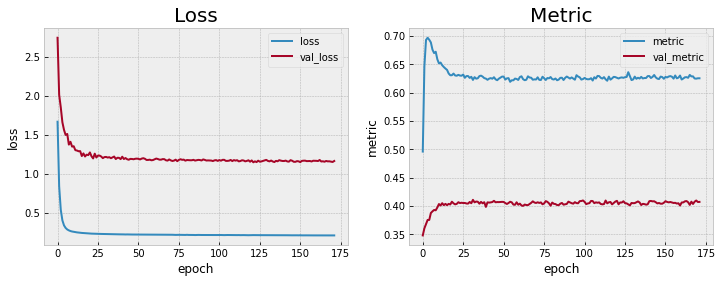

In [38]:
total_hist = []
for i, (train, valid) in enumerate(train_valid):
    print(f'Start learning {i}-th fold...')
    valid_q, valid_a = query_answer_split(valid)
    train, valid_q, valid_a = map(list_aggregation, (train, valid_q, valid_a))
    
    train_gen = train_generator(train, n_item, batch_size, user_specific = True)
    valid_gen = valid_generator(valid_q, valid_a, n_item, batch_size, user_specific = True)

    steps_per_epoch = train.index.size // batch_size + 1
    validation_steps = valid_q.index.size // batch_size + 1

    optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
    model = CDAE(n_user, n_item, latent_dim = 512, optimizer = optimizer, user_specific = True)

    early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
    model_checkpoint = ModelCheckpoint(f'DAE_{i+1}.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)
    hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                     steps_per_epoch = steps_per_epoch, validation_steps = validation_steps,
                     verbose = 1, callbacks = [early_stopping, model_checkpoint])
    show_history(hist, 'loss', 'batch_ndcg')
    total_hist.append(hist)

In [39]:
print(f"The average of nDCG: {np.mean([h.history['val_batch_ndcg'][-1] for h in total_hist]):0.5f}")

The average of nDCG: 0.41065


In [42]:
models = [load_model(f'DAE_{i+1}.h5', compile = False) for i in range(5)]

pred = test_predictor(test_q, models, n_item, batch_size, user_specific = True)
pred

array([[207, 385,  37, ..., 726, 369, 792],
       [ 48,  38,  92, ..., 123, 433, 150],
       [ 44, 217, 714, ..., 171, 205, 432],
       ...,
       [104,  38,  68, ...,   4, 167,  22],
       [ 44, 127,  97, ...,   0,   5, 104],
       [127,  64,  22, ...,  38, 246,   0]])

In [43]:
m_ndcg, m_recall, m_precision, map_k = evaluation(test_a, pred)
print(f'nDCG: {m_ndcg:.5f}',
      f'\nRecall: {m_recall:.5f}',
      f'\nPrecision: {m_precision:.5f}',
      f'\nMAP: {map_k:.5f}')

nDCG: 0.53463 
Recall: 0.22671 
Precision: 0.16921 
MAP: 0.14732
